In [7]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf
from scipy.stats import entropy

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

In [8]:
class DataGenerator:
    def __init__(
        self,
        choice_probability: list[float] = [0.75, 0.2, 0.05],
        alternative_probability: list[float] = None,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.choice_probability = choice_probability
        self.alternative_probability = alternative_probability
        self.total_panel = total_panel
        self.choices = np.fromiter(range(len(choice_probability)), dtype=int)
        self.is_treatment_group = not control_group
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4, use_alternative_for_n_terms: int = None):

        if use_alternative_for_n_terms is not None and use_alternative_for_n_terms > 0:
            mediated_choices = np.random.choice(a = self.choices, size = (n_samples, use_alternative_for_n_terms), p = self.alternative_probability)
            non_mediated_choices = np.random.choice(a = self.choices, size = (n_samples, self.total_panel - use_alternative_for_n_terms), p = self.choice_probability)
            full_panel_data = np.hstack([mediated_choices, non_mediated_choices])
        else:
            full_panel_data = np.random.choice(a = self.choices, size = (n_samples, self.total_panel), p = self.choice_probability)
            
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [9]:
c_gen = DataGenerator(
    choice_probability= [0.9, 0.1],
    total_panel = 52,
    control_group = True
)
c_gen.generate_data(n_samples=10, n_surrogates=4)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0,0,0,1,5,0
1,0,0,0,0,3,0
2,0,0,0,0,2,0
3,0,1,0,0,10,0
4,0,0,0,0,3,0
5,0,0,0,0,7,0
6,0,0,0,0,3,0
7,0,0,0,0,5,0
8,0,0,0,0,2,0
9,0,0,0,1,10,0


In [ ]:
t_gen = DataGenerator(
    choice_probability=[0.9, 0.1],
    alternative_probability=[0.8, 0.2],
    total_panel = 52,
    control_group = False
)
t_gen.generate_data(n_samples=10, n_surrogates=4, use_alternative_for_n_terms=4)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,1,0,0,0,7,1
1,1,0,0,0,4,1
2,0,0,1,0,12,1
3,0,0,0,1,10,1
4,0,0,0,0,6,1
5,0,0,0,0,2,1
6,0,0,0,0,6,1
7,0,1,1,0,7,1
8,0,0,1,0,10,1
9,0,0,0,0,11,1


In [30]:
def surrogate_index_model_experiment(
        n_surrogate_list:list = [4],
        sample_size = 1000,
        train_control_probabilities = [0.75, 0.2, 0.05],
        train_treatment_probabilities = [0.74, 0.205, 0.055],
        test_control_probabilities = [0.75, 0.2, 0.05],
        test_treatment_probabilities = [0.74, 0.205, 0.055],
        calculate_kl_divergence: bool = True,
        mediation_term_list: list = None
    ) -> tuple[float, list[float]]:
    
    
    train_control_data = (
        DataGenerator(
            choice_probability = train_control_probabilities,
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    test_control_data = (
        DataGenerator(
            choice_probability = test_control_probabilities,
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    
    predicted_experiment_treatment_effects = list()
    kl_divergences = list()

    if mediation_term_list is not None:
        space = zip(n_surrogate_list, mediation_term_list)
    else:
        space = zip(n_surrogate_list, [None] * len(n_surrogate_list))

    for values in space:
        n_surrogates, mediation_terms = values

        train_treatment_data = (
            DataGenerator(
                choice_probability = train_control_probabilities,
                alternative_probability = train_treatment_probabilities,
                control_group=False
            )
            .generate_data(
                n_surrogates=max(n_surrogate_list),
                n_samples=sample_size,
                use_alternative_for_n_terms=mediation_terms
            )
        )

        test_treatment_data = (
            DataGenerator(
                choice_probability = test_control_probabilities,
                alternative_probability = test_treatment_probabilities,
                control_group=False
            )
            .generate_data(
                n_surrogates=max(n_surrogate_list),
                n_samples=sample_size,
                use_alternative_for_n_terms=mediation_terms
            )
        )

        train_data = pd.concat([train_control_data, train_treatment_data])
        
        test_data = pd.concat([test_control_data, test_treatment_data])

        observed_experiment_analysis = (
            smf.ols(
                formula = 'unit_total ~ 1 + treatment',
                data = test_data
            )
            .fit()
        )
        observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

        surrogate_index_model = (
            smf.ols(
                formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
                data = train_data
            )
            .fit()
        )
        predicted_test_data = (
            test_data
            .assign(
                predicted_unit_total = surrogate_index_model.predict(test_data)
            )
        )

        predicted_experiment_analysis = (
            smf.ols(
                formula = 'predicted_unit_total ~ 1 + treatment',
                data = predicted_test_data
            )
            .fit()
        )
        predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']
        predicted_experiment_treatment_effects.append(predicted_experiment_treatment_effect)
        if calculate_kl_divergence:
            min_value = min(
                train_data.loc[:, 'unit_total'].min(),
                test_data.loc[:, 'unit_total'].min()
            )
            max_value = max(
                train_data.loc[:, 'unit_total'].max(),
                test_data.loc[:, 'unit_total'].max()
            )
            bins = np.arange(min_value, max_value + 1)
            train_hist, _ = np.histogram(train_data.loc[:, 'unit_total'], bins=bins)
            test_hist, _ = np.histogram(test_data.loc[:, 'unit_total'], bins=bins)
            kl_divergence = entropy(
                train_hist + 1e-6,
                test_hist + 1e-6
            )
            kl_divergences.append(kl_divergence)

    if calculate_kl_divergence:
        return observed_experiment_treatment_effect, predicted_experiment_treatment_effects, kl_divergences
    else:
        return observed_experiment_treatment_effect, predicted_experiment_treatment_effects


In [49]:
n_surrogate_list = [4]
mediation_term_list = [4]

train_treatment_probability_space = [
    [0.7, 0.25, 0.05],
    [0.65, 0.27, 0.08],
    [0.60, 0.29, 0.11],
    [0.55, 0.31, 0.14],
    [0.5, 0.33, 0.17],
    [0.45, 0.35, 0.20],
    [0.4, 0.37, 0.23],
    [0.35, 0.39, 0.26],
    [0.2, 0.4, 0.4],
]

predicted_effect_df_list = list()

for train_treatment_probability in train_treatment_probability_space:
    observed_effects = list()
    predicted_effects = list()
    kl_divergences = list()
    for i in range(100):
        observed_effect, predicted_effect, kl_div = surrogate_index_model_experiment(
            train_control_probabilities=[0.75, 0.2, 0.05],
            train_treatment_probabilities=train_treatment_probability,
            test_control_probabilities=[0.75, 0.2, 0.05],
            test_treatment_probabilities=[0.75, 0.2, 0.05],
            n_surrogate_list=n_surrogate_list,
            mediation_term_list=mediation_term_list, 
            calculate_kl_divergence=True
        )
        observed_effects.append(observed_effect)
        predicted_effects.append(predicted_effect)
        kl_divergences.append(kl_div)
    predicted_effect_df = (
        pd.DataFrame(
            data = np.array(predicted_effects),
            columns = [f'{n_surrogate}_surrogates' for n_surrogate in n_surrogate_list]
        )
        .assign(
            kl_div = np.array(kl_divergences).flatten().mean().round(3)
        )
    )
    predicted_effect_df_list.append(predicted_effect_df)

Text(0.5, 0, 'Treatment Effect')

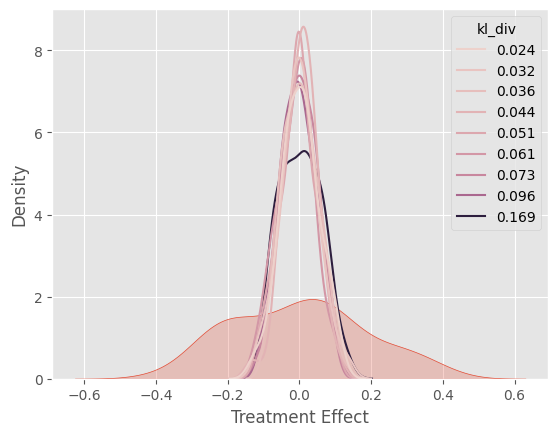

In [50]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
sns.kdeplot(data=pd.concat(predicted_effect_df_list), x='4_surrogates', hue='kl_div', ax=ax, cbar=True, common_norm=False)

# ax.legend()
ax.set_xlabel('Treatment Effect')

# Add more surrogates

In [ ]:
n_surrogate_list = [16]
mediation_term_list = [16]

train_treatment_probability_space = [
    [0.7, 0.25, 0.05],
    [0.65, 0.27, 0.08],
    [0.60, 0.29, 0.11],
    [0.55, 0.31, 0.14],
    [0.5, 0.33, 0.17],
    [0.45, 0.35, 0.20],
    [0.4, 0.37, 0.23],
    [0.35, 0.39, 0.26],
    [0.2, 0.4, 0.4],
]

predicted_effect_df_list = list()

for train_treatment_probability in train_treatment_probability_space:
    observed_effects = list()
    predicted_effects = list()
    kl_divergences = list()
    for i in range(100):
        observed_effect, predicted_effect, kl_div = surrogate_index_model_experiment(
            train_control_probabilities=[0.75, 0.2, 0.05],
            train_treatment_probabilities=train_treatment_probability,
            test_control_probabilities=[0.9, 0.08, 0.02],
            test_treatment_probabilities=[0.9, 0.08, 0.02],
            n_surrogate_list=n_surrogate_list,
            mediation_term_list=mediation_term_list, 
            calculate_kl_divergence=True
        )
        observed_effects.append(observed_effect)
        predicted_effects.append(predicted_effect)
        kl_divergences.append(kl_div)
    predicted_effect_df = (
        pd.DataFrame(
            data = np.array(predicted_effects),
            columns = [f'{n_surrogate}_surrogates' for n_surrogate in n_surrogate_list]
        )
        .assign(
            kl_div = np.array(kl_divergences).flatten().mean().round(3)
        )
    )
    predicted_effect_df_list.append(predicted_effect_df)

KeyboardInterrupt: 

Text(0.5, 0, 'Treatment Effect')

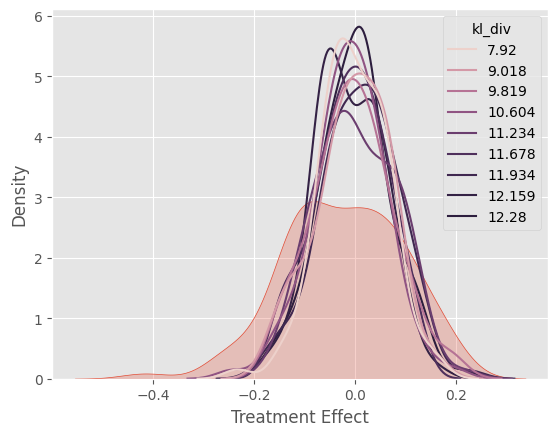

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
sns.kdeplot(data=pd.concat(predicted_effect_df_list), x='16_surrogates', hue='kl_div', ax=ax, cbar=True, common_norm=False)

# ax.legend()
ax.set_xlabel('Treatment Effect')